# Dados do Case
### Contexto:
<p>O projeto visa o reconhecimento de padrões de sinais biomédicos, especificamente sinais de eletromiografia (EMG) de dois canais, capturados via hardware (Arduino). O objetivo é identificar e classificar 6 movimentos da mão. Os sinais foram capturados dos musculos do anti-braço. O projeto visa possiveis aplicações de controle (provavelmente próteses, interfaces humano-máquina ou reabilitação). O desafio principal é distinguir movimentos sutis e semelhantes em tempo real, lidando com o ruído inerente à captação elétrica muscular.</p>

### Solução desenvolvida:
- Foi implementado um sistema completo de Machine Learning em Python composto por dois estágios (Offline e Online):
- Processamento de Sinais (Feature Engineering):
- Domínio: Conversão do sinal temporal para o domínio da frequência utilizando a Transformada Rápida de Fourier (FFT).
- Filtragem: Aplicação de filtro "Passa Alta" (removendo frequências centrais/baixas do espectro) para eliminar ruídos de base.
- Extração de Atributos: Segmentação do espectro em 20 partes e cálculo do Desvio Padrão (np.std) de cada segmento, gerando um vetor de características robusto.
- Utilização de um algoritmo SVM (Support Vector Machine) com kernel RBF (gamma=0.006, C=100).

### Ferramentas ultilizadas:
- Linguagem: Python 3.
- classificador SVM, validação cruzada e métricas (Matriz de Confusão)
- Scripts modulares (.py) estruturados para execução em terminal ou adaptação para Notebooks.
- Bibliotecas: Numpy, Scipy, Scikit-learn, Matplotlib e PySerial.

### Resultados alcançados:
- Capacidade de Classificação: O sistema foi capaz de classificar com sucesso 6 movimentos distintos da mão a partir de sinais EMG.
- acuracia para os melhores casos de 98%

## Bloco 1: Instalação de Dependências
Execute o comando:
- Criar ambiente virtual e ativa-lo:
```shell
    python3 -m venv .venv
    source .venv/bin/activate
```
- instalar dependências:
```shell
    pip3 install -r requirements.txt
```
Obs: mantenha o arquivo BD_EMG.txt na raiz

## Bloco 2: Importações Globais
Importações e declarações

In [1]:
import numpy as np
from scipy.stats import kurtosis
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import random
import time
import os

# Configuração para gráficos aparecerem no notebook
%matplotlib inline
nome_bd = 'BD_EMG'
# Classes: 1-Aberta, 2-Baixo, 3-Cima, 4-Fechar, 5-Interno, 6-Pressão
class_selected = [1, 2, 6]

## Bloco 3: Funções de Processamento de Sinais (Atributos.py)
Funções matemática para extração de características (Fourier, Passa-Alta, Desvio Padrão) 
obs: re-execute sem reiniciar o kernel.

In [2]:
# --- Funções matemáticas ---

def transFourier(sinalt):
    sinalf = np.fft.fft(sinalt)
    sinalf = np.fft.fftshift(sinalf)
    return sinalf

def modtransFourier(sinalt):
    if type(sinalt[1]) == float:
        modSinalF = abs(transFourier(sinalt))
        return np.ndarray.tolist(modSinalF)
    else:
        chf = []
        for x in sinalt:
            sinalf = np.ndarray.tolist(abs(transFourier(x)))
            chf.append(sinalf)
        return chf

def PassAlta(sinalf):
    # Lógica de filtro passa alta adaptada do seu código
    sinalR = []
    if type(sinalf[1]) == float:
        # Implementação para vetor único se necessário
        pass 
    else:
        for s in sinalf:
            tam = len(s)
            # Zera as frequências centrais (baixa frequência)
            s[tam//2 - 10 : tam//2 + 10] = [0]*20 
            sinalR.append(s)
    return sinalR

def divdeS(sinal, npart):
    # Divide o sinal em partes para análise
    vets = []
    tam = len(sinal[0])
    interv = tam // npart
    
    for x in range(npart):
        temp = []
        for s in sinal:
            temp.append(s[x*interv : (x+1)*interv])
        vets.append(temp)
    return vets

def DesvPadr(sinal):
    std = []
    for s in sinal:
        std.append(np.std(s))
    return std

# Funções auxiliares de junção de atributos
def juntaAtributosVet(ch1, ch2):
    atrib = []
    for a in range(len(ch1)):
        atrib.append(ch1[a] + ch2[a]) # Concatenação de listas
    return atrib

def Atrib_com_rotul(atrib, rot):
    vetfinal = atrib
    for x in range(len(rot)):
        vetfinal[x].append(rot[x])
    return vetfinal

def Atrib_e_rotul(atrib):
    # Separa features e labels
    rot = []
    atr = []
    for x in atrib:
        rot.append(x[-1])
        atr.append(x[0:-1])
    return atr, rot

## Bloco 4: Funções de Banco de Dados
Funções de leitura do arquivo BD_EMG.txt

In [3]:
# --- Funções do  BancoDeDados.py ---

def BD_to_Vet(nome_arquivo):
    # Adiciona extensão se não houver
    if not nome_arquivo.endswith('.txt'):
        nome_arquivo += '.txt'
        
    print(f"Lendo arquivo: {nome_arquivo}")
    with open(nome_arquivo, 'r') as file:
        vetBD = []
        for temp in file:
            # Converte string para float
            s = [float(x) for x in temp.split()]
            vetBD.append(s)
    return vetBD

def extractCaracteristcsVET(BD_Vet):
    sinal_ch1 = []
    sinal_ch2 = []
    classe = []

    for s in BD_Vet:
        # Divide o vetor ao meio para separar Canal 1 e Canal 2
        # O último elemento é a classe
        meio = len(s) // 2
        sinal_ch1.append(s[0:meio])
        sinal_ch2.append(s[meio:-1])
        classe.append(int(s[-1]))
        
    return [sinal_ch1, sinal_ch2, classe]

def SelectClasses(BD_entrada, clas_escolhidas):
    BD_saida = []
    for linha in BD_entrada:
        if linha[-1] in clas_escolhidas:
            BD_saida.append(linha)
    return BD_saida

##   Bloco 5: Funções de Visualização (plotSinal.py)

In [4]:
# --- Funções ---

def Plotagem1sinalTempo(sinal_ch1, classe):
    NomeSinal = ["MAO ABERTA", "PARA BAIXO", "PARA CIMA", "FECHAR MAO", "LATERAL INTERNO", "PRESSAO DE PUNHO"]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Movimento {NomeSinal[classe - 1]} no domínio do tempo")
    plt.plot(sinal_ch1)
    plt.ylabel("Volts")
    plt.ylim(-2, 2)
    plt.grid(True)
    plt.show()

def PlotGeneric(Sinal):
    plt.figure(figsize=(10, 4))
    plt.title('Sinal Genérico')
    plt.plot(Sinal)
    plt.show()

## Bloco 6: Execução Principal - Carregamento (Principal.py)
Lógica 

In [5]:
# 1. Carregar o Banco de Dados
nome_bd = 'BD_EMG' 
vet = BD_to_Vet(nome_bd)

# 2. Selecionar Classes (1 a 6)
vet = SelectClasses(vet, class_selected)

# 3. Embaralhar os dados (Crucial para o treino do SVM)
random.shuffle(vet)

print(f"Total de amostras carregadas: {len(vet)}")

Lendo arquivo: BD_EMG.txt
Total de amostras carregadas: 930


## Bloco 7: Pré-processamento e Feature Engineering
Transformação pesada dos dados (Fourier -> Filtro -> Estatística).

In [6]:
# Extrair canais brutos e classes
ch1, ch2, cls = extractCaracteristcsVET(vet)

# --- Processamento de Sinais ---

# 1. Transformada de Fourier (Módulo)
print("Calculando FFT...")
ch1f = modtransFourier(ch1)
ch2f = modtransFourier(ch2)

# 2. Filtro Passa Alta (Remove frequências centrais)
print("Aplicando Filtro Passa Alta...")
ch1f = PassAlta(ch1f)
ch2f = PassAlta(ch2f)

# 3. Segmentação (Divide o espectro em 20 partes)
divch1 = divdeS(ch1f, 20)
divch2 = divdeS(ch2f, 20)

# 4. Extração de Atributos (Desvio Padrão de cada segmento)
print("Calculando Desvio Padrão...")
DP1 = []
DP2 = []

for x in divch1:
    DP1.append(DesvPadr(x))
for x in divch2:
    DP2.append(DesvPadr(x))

# 5. Fusão dos atributos dos dois canais
# Nota: O código original usa juntaAtributosVet que soma listas ou append dependendo da implementação.
# Aqui assumimos a concatenação de features.
atributos = []
# Transpondo a lógica para ficar amostra por amostra
# O código original fazia loops complexos, aqui simplificamos para criar a matriz de treino X
num_amostras = len(cls)
X = [] # Matriz de Features
y = cls # Vetor de Labels

# Reconstruindo a matriz de características transpondo as listas de DP
# DP1 é uma lista de listas onde DP1[segmento][amostra]. Precisamos de [amostra][todas_features]
for i in range(num_amostras):
    features_amostra = []
    # Pega features do canal 1
    for seg in range(len(DP1)): 
        features_amostra.append(DP1[seg][i])
    # Pega features do canal 2
    for seg in range(len(DP2)):
        features_amostra.append(DP2[seg][i])
    X.append(features_amostra)

print(f"Dimensão da matriz de features: {len(X)} amostras x {len(X[0])} atributos")

Calculando FFT...
Aplicando Filtro Passa Alta...
Calculando Desvio Padrão...
Dimensão da matriz de features: 930 amostras x 40 atributos


## Bloco 8: Visualização
visualização pós processamento

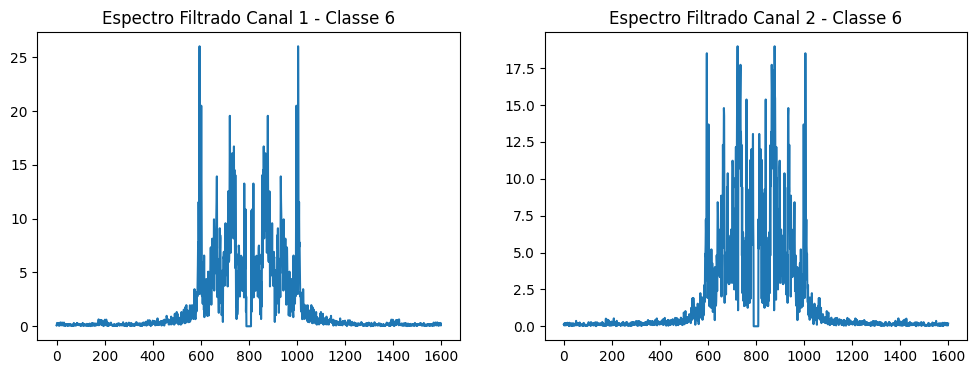

In [7]:
# Visualizar o espectro de uma amostra aleatória
idx = 0
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ch1f[idx])
plt.title(f"Espectro Filtrado Canal 1 - Classe {cls[idx]}")
plt.subplot(1,2,2)
plt.plot(ch2f[idx])
plt.title(f"Espectro Filtrado Canal 2 - Classe {cls[idx]}")
plt.show()

## Bloco 9: Classificação 
Treinamento do SVM.

In [8]:
# Configuração do SVM
# Parâmetros retirados do seu código original (gamma=0.006, C=100)
clf = svm.SVC(gamma=0.006, C=100, kernel='rbf')

# Validação Cruzada (Cross-Validation)
print("Iniciando Validação Cruzada (5-fold)...")
scores = cross_val_score(clf, X, y, cv=5)

print("\n--- Resultados ---")
print(f"Acurácias por fold: {scores}")
print(f"Acurácia Média: {scores.mean() * 100:.2f}% (+/- {scores.std() * 2:.2f})")

# Treino final em toda a base (opcional, para uso futuro)
clf.fit(X, y)
print("Modelo treinado na base completa.")

Iniciando Validação Cruzada (5-fold)...

--- Resultados ---
Acurácias por fold: [0.96236559 0.96774194 0.97311828 0.9516129  0.96236559]
Acurácia Média: 96.34% (+/- 0.01)
Modelo treinado na base completa.


## Bloco 10: Avaliação Detalhada do Modelo
cross_val_predict para gerar previsões para toda a base de dados 

--- Iniciando Avaliação Detalhada ---



Relatório de Classificação:

                 precision    recall  f1-score   support

   1-Mão Aberta       0.98      0.97      0.98       319
   2-Para Baixo       0.96      0.96      0.96       314
6-Pressão Punho       0.96      0.96      0.96       297

       accuracy                           0.96       930
      macro avg       0.96      0.96      0.96       930
   weighted avg       0.96      0.96      0.96       930



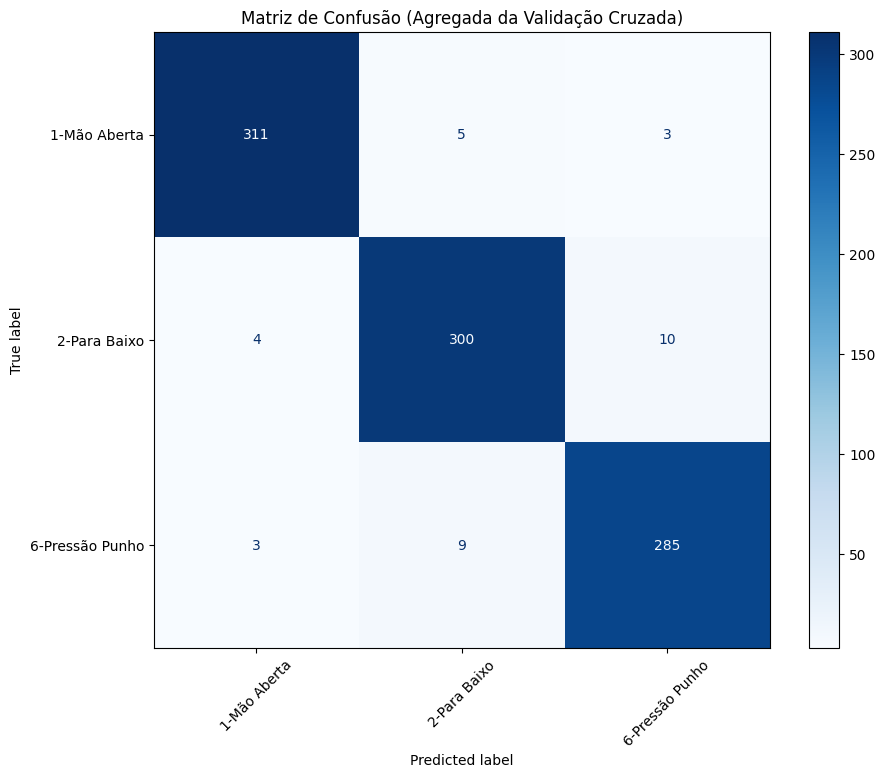

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# Definição dos nomes das classes para os relatórios (na ordem 1, 2, 3, 4, 5, 6)
nomes_classes = [
    "1-Mão Aberta", 
    "2-Para Baixo", 
    "3-Para Cima", 
    "4-Fechar Mão", 
    "5-Lateral Interno", 
    "6-Pressão Punho"
]
nomes_classes = [nomes_classes[x-1] for x in class_selected]
print("--- Iniciando Avaliação Detalhada ---")

# 1. Gerar previsões para todas as amostras usando Validação Cruzada (5-folds)
# O modelo faz a predição de cada amostra usando um classificador treinado nas outras 4 partes dos dados.
y_pred = cross_val_predict(clf, X, y, cv=5)

# 2. Gerar Relatório de Métricas (Precision, Recall, F1-Score)
# Precision: Das classificações como 'Mão Aberta', quantas realmente eram?
# Recall: Das amostras reais de 'Mão Aberta', quantas o modelo encontrou?
relatorio = classification_report(y, y_pred, target_names=nomes_classes)
print("\nRelatório de Classificação:\n")
print(relatorio)

# 3. Gerar e Plotar a Matriz de Confusão
cm = confusion_matrix(y, y_pred)

# Configuração do gráfico
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nomes_classes)

# Plotagem com mapa de cores azul
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, xticks_rotation=45)

plt.title("Matriz de Confusão (Agregada da Validação Cruzada)")
plt.show()